#Laser segmentation

In this article is presented a method to detect the laser and generate a vector of 2D points.

In [1]:
import cv2

def load_image(path):
    image = cv2.imread(path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Load images
image = load_image('/home/jesus/code/3DScanScience/notebooks/images/3. Laser segmentation/laser.png')
image_background = load_image('/home/jesus/code/3DScanScience/notebooks/images/3. Laser segmentation/laser_background.png')

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_image(image):
    if len(image.shape) == 2:
        image = cv2.merge((image,image,image))
    f, axarr = plt.subplots(1, 1, figsize=(15,15))
    axarr.axis('off')
    axarr.imshow(image)
    axarr.plot()
    
def plot_images(images):
    f, axarr = plt.subplots(1, len(images), figsize=(15,15))
    for i in range(len(images)):
        if len(images[i].shape) == 2:
            image = cv2.merge((images[i],images[i],images[i]))
        else:
            image = images[i]
        axarr[i].axis('off')
        axarr[i].imshow(image)
        axarr[i].plot()

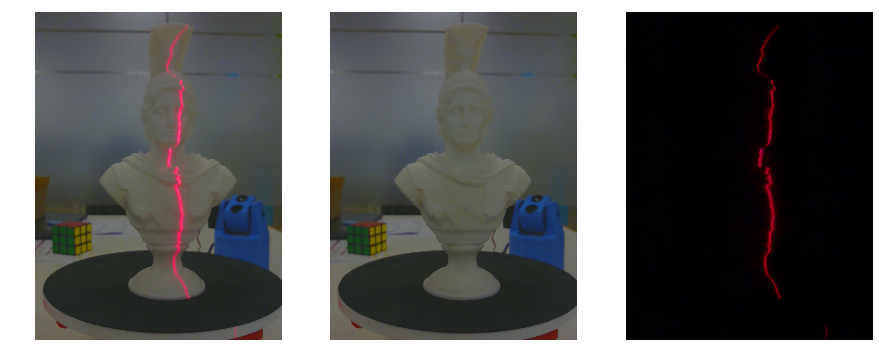

In [3]:
# Show images
plot_images((image, image_background, cv2.subtract(image, image_background)))

##Red channel selection

###R from RGB

In [4]:
def r_rgb(image):
    return cv2.split(image)[0]

image_r = r_rgb(image)
image_background_r = r_rgb(image_background)
image_diff_r = cv2.subtract(image_r, image_background_r)

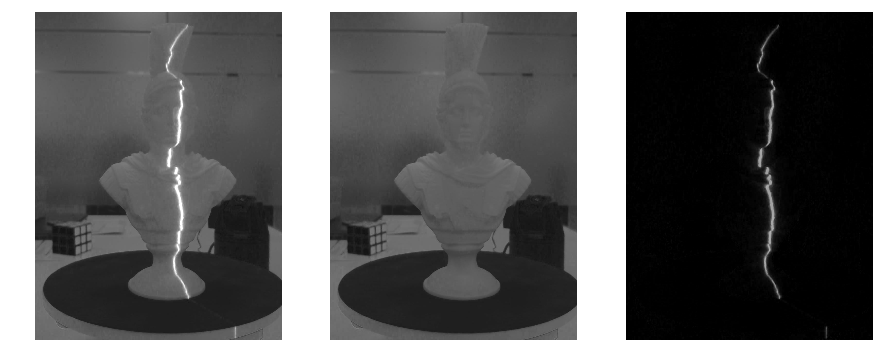

In [5]:
plot_images((image_r, image_background_r, image_diff_r))

###Cr from YCrCb

In [6]:
def cr_ycrcb(image):
    return cv2.split(cv2.cvtColor(image, cv2.COLOR_RGB2YCR_CB))[1]

image_cr = cr_ycrcb(image)
image_background_cr = cr_ycrcb(image_background)
image_diff_cr = cv2.subtract(image_cr, image_background_cr)

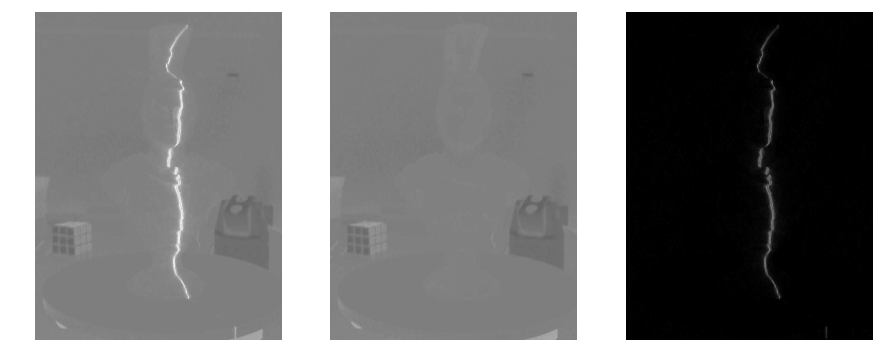

In [7]:
plot_images((image_cr, image_background_cr, image_diff_cr))

###U from YUV

In [8]:
def u_yuv(image):
    return cv2.split(cv2.cvtColor(image, cv2.COLOR_RGB2YUV))[1]

image_u = u_yuv(image)
image_background_u = u_yuv(image_background)
image_diff_u = cv2.subtract(image_u, image_background_u)

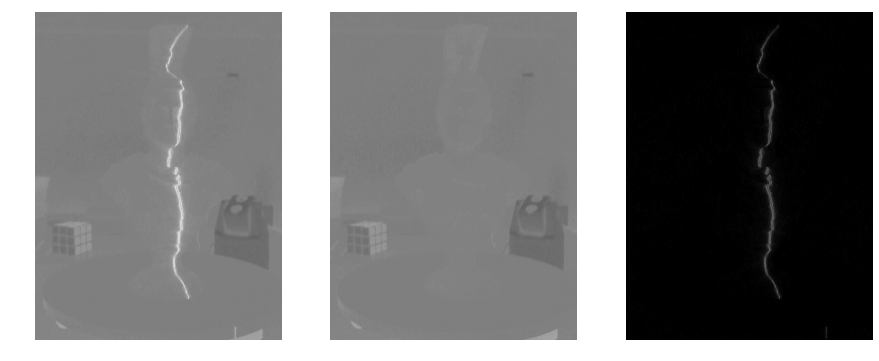

In [9]:
plot_images((image_u, image_background_u, image_diff_u))

###Conclusions
* Obtain R from RGB and subtract are conmutative operations
* Obtain Cr from YCrCb and subtract are not conmutative operations
* Obtain U from YUV and subtract are conmutative operations
* R from RGB + subtract will be used for future processing in order to detect better laser white sheens in the camera

##Morphological Transformation

###Open
It is used to remove background noise. Is is composed by an erosion followeb by dilation

![](http://docs.opencv.org/master/opening.png)

In [10]:
# Open image
open_value = 2
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (open_value, open_value))
image_open = cv2.morphologyEx(image_diff_r, cv2.MORPH_OPEN, kernel)

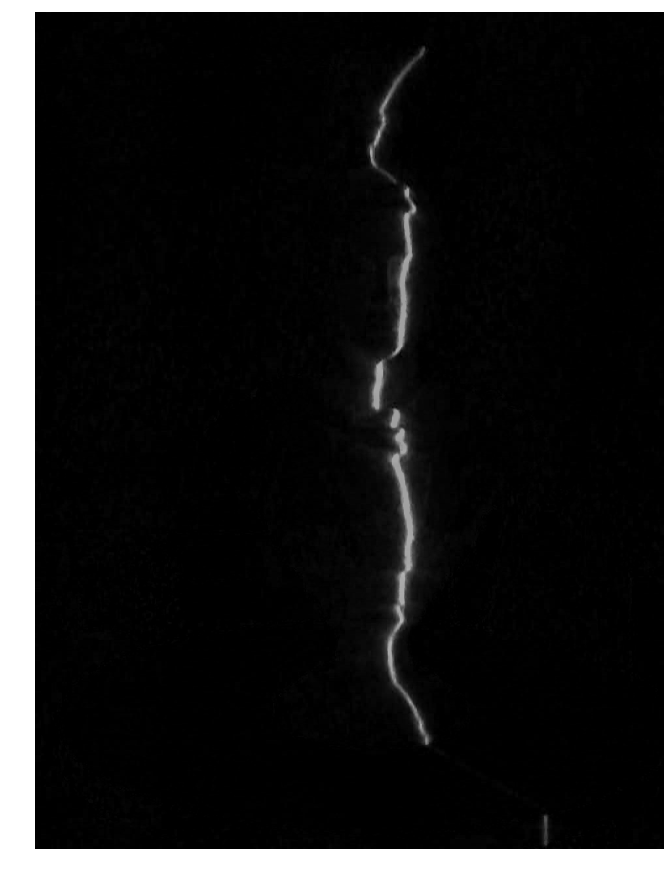

In [11]:
plot_image(image_open)

##Threshold
It is used to filter near line noise and also background noise.

###Method 1: fixed threshold

![](http://docs.opencv.org/_images/Threshold_Tutorial_Theory_Zero.png)

$$
dst(x, y) =
  \begin{cases}
    src(x,y)       & \quad \text{if } src(x,y) \: > \text{ threshold}\\
    0       & \quad \text{otherwise } \\
  \end{cases}
$$

In [12]:
# Threshold image
threshold_value = 50
image_threshold = cv2.threshold(image_open, threshold_value, 255.0, cv2.THRESH_TOZERO)[1]

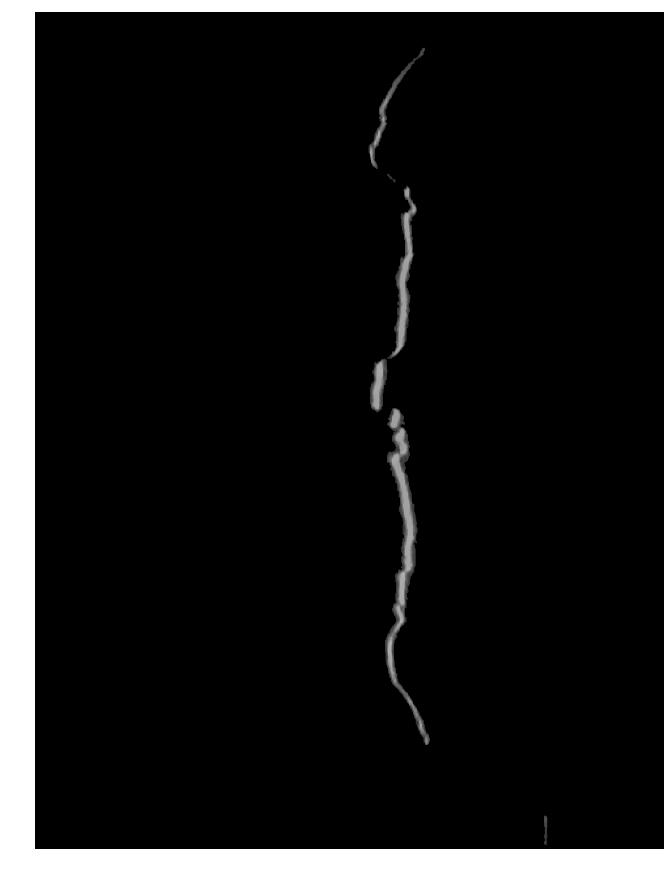

In [13]:
plot_image(image_threshold)

###Method 2: adaptative threshold

In [14]:
#TODO

##Compute 2d points

###Method 1: Center of mass

$$
\forall \: j \: \in  \: H :\:\:\:
cm_j = {\frac{\displaystyle\sum_{i}^{w} v_j · i}{\displaystyle\sum_{i}^{w} v_j}}
\: \Leftrightarrow \:
{\displaystyle\sum_{i}^{w} v_j} > 0 
$$

In [15]:
import numpy as np

h, w = image_threshold.shape
weight_matrix = np.array((np.matrix(np.linspace(0, w - 1, w)).T * np.matrix(np.ones(h))).T)

# Compute center of mass
s = image_threshold.sum(axis=1)
v = np.where(s > 0)[0]
u = (weight_matrix * image_threshold).sum(axis=1)[v] / s[v]

In [16]:
# Compose line image
image_line = np.zeros_like(image_threshold)
image_line[v, u.astype(int)] = 255.0

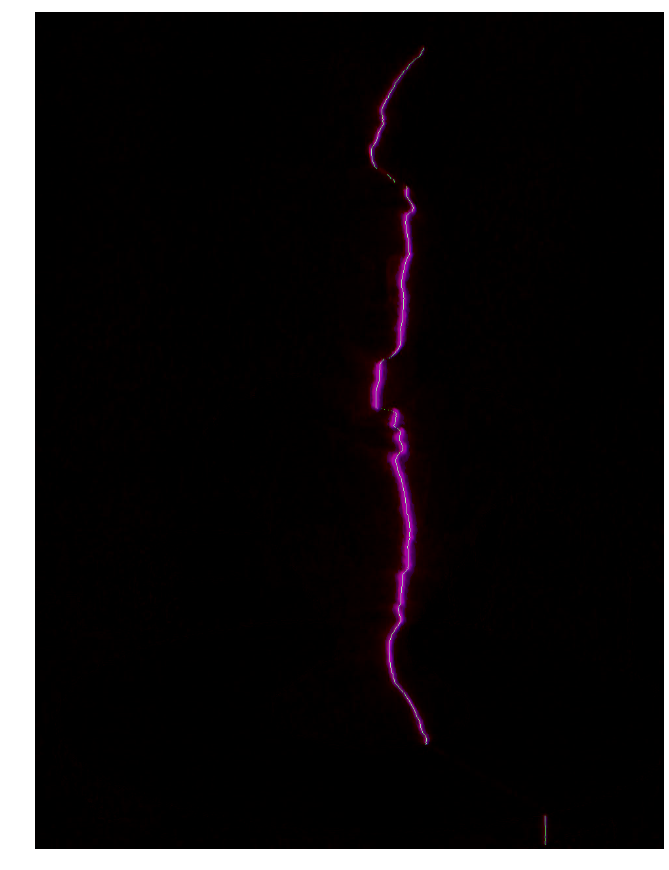

In [17]:
# Show images
image_comb = cv2.merge((image_diff_r,image_line,image_threshold))
plot_image(image_comb)

###Method 2: Convolution and parabolic estimator

In [18]:
#TODO

#References